# Imports

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
import json

with open("iclr2025.json", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

In [3]:
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from datasets import Dataset

MODEL_NAME = "bert-base-uncased"
RANDOM_SEED = 42

## Initial Data Checks

In [4]:
records = data
len(records), records[0]

(11672,
 {'venue': 'ICLR.cc',
  'year': '2025',
  'paper_id': '5sRnsubyAK',
  'title': 'Neuroacoustic Patterns: Constant Q Cepstral Coefficients for the Classification of Neurodegenerative Disorders',
  'abstract': 'Early identification of neurodegenerative diseases is crucial for effective diagnosis in neurological disorders. However, the quasi-periodic nature of vocal tract sampling often results in inadequate spectral resolution in traditional spectral features, such as Mel Frequency Cepstral Coefficients (MFCC), thereby limiting their classification effectiveness. In this study, we propose the use of Constant Q Cepstral Coefficients (CQCC), which leverage geometrically spaced frequency bins to provide superior spectrotemporal resolution, particularly for capturing the fundamental frequency and its harmonics in speech signals associated with neurodegenerative disorders. Our results demonstrate that CQCC, when integrated with Random Forest and Support Vector Machine classifiers, sign

In [5]:
examples = []

for r in records:
    title = (r.get("title") or "").strip()
    abstract = (r.get("abstract") or "").strip()
    label = r.get("label")

    # Skip if something critical is missing
    if not title or not abstract:
        continue
    if label is None:
        continue

    text = f"{title} {abstract}".strip()
    examples.append({"text": text, "label": int(label)})

len(examples)

11672

In [6]:
import collections

label_counts = collections.Counter(e["label"] for e in examples)
label_counts, {k: v / len(examples) for k, v in label_counts.items()}

(Counter({0: 7964, 1: 3708}), {0: 0.6823166552433173, 1: 0.31768334475668264})

# Building Model and Making Training Data

## Training, Validation, and Test Splits

In [7]:
def make_splits(examples, test_size=0.2, val_size=0.2, seed=RANDOM_SEED):
    texts = [e["text"] for e in examples]
    labels = [e["label"] for e in examples]

    X_train, X_temp, y_train, y_temp = train_test_split(
        texts, labels,
        test_size=test_size,
        random_state=seed,
        stratify=labels,
    )

    val_ratio = val_size / (1.0 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1 - val_ratio,
        random_state=seed,
        stratify=y_temp,
    )

    def to_hf(texts, labels):
        return Dataset.from_dict({"text": texts, "label": labels})

    return (
        to_hf(X_train, y_train),
        to_hf(X_val, y_val),
        to_hf(X_test, y_test),
    )

train_ds, val_ds, test_ds = make_splits(examples)
len(train_ds), len(val_ds), len(test_ds)

(9337, 583, 1752)

## Set up tokenizer and tokenize data

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

tokenized_train = train_ds.map(tokenize, batched=True)
tokenized_val = val_ds.map(tokenize, batched=True)
tokenized_test = test_ds.map(tokenize, batched=True)

for ds in [tokenized_train, tokenized_val, tokenized_test]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/9337 [00:00<?, ? examples/s]

Map:   0%|          | 0/583 [00:00<?, ? examples/s]

Map:   0%|          | 0/1752 [00:00<?, ? examples/s]

## Build BERT

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # softmax for positive class (label=1)
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits[:, 1] / exp_logits.sum(axis=1)

    preds = (probs >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
    }
    try:
        metrics["auroc"] = roc_auc_score(labels, probs)
    except ValueError:
        metrics["auroc"] = float("nan")
    return metrics

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create Trainer and Define Arguments

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="outputs/bert_acceptance_baseline",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-Tuning

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auroc
1,0.648100,0.605663,0.698113,0.128713,0.602805
2,0.661800,0.597593,0.704974,0.148515,0.609575
3,0.540500,0.633064,0.708405,0.351145,0.619150


TrainOutput(global_step=3504, training_loss=0.5922962530562866, metrics={'train_runtime': 307.5646, 'train_samples_per_second': 91.074, 'train_steps_per_second': 11.393, 'total_flos': 3685001885844480.0, 'train_loss': 0.5922962530562866, 'epoch': 3.0})

# Evaluation

In [13]:
test_metrics = trainer.evaluate(tokenized_test)
test_metrics

{'eval_loss': 0.6339169144630432,
 'eval_accuracy': 0.6894977168949772,
 'eval_f1': 0.27851458885941643,
 'eval_auroc': 0.646172336861399,
 'eval_runtime': 5.8313,
 'eval_samples_per_second': 300.449,
 'eval_steps_per_second': 18.864,
 'epoch': 3.0}

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

preds_output = trainer.predict(tokenized_test)
logits = preds_output.predictions
labels = preds_output.label_ids

exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = exp_logits[:, 1] / exp_logits.sum(axis=1)
y_pred = (probs >= 0.5).astype(int)

print(confusion_matrix(labels, y_pred))
print(classification_report(labels, y_pred, digits=3))

[[1103   92]
 [ 452  105]]
              precision    recall  f1-score   support

           0      0.709     0.923     0.802      1195
           1      0.533     0.189     0.279       557

    accuracy                          0.689      1752
   macro avg      0.621     0.556     0.540      1752
weighted avg      0.653     0.689     0.636      1752



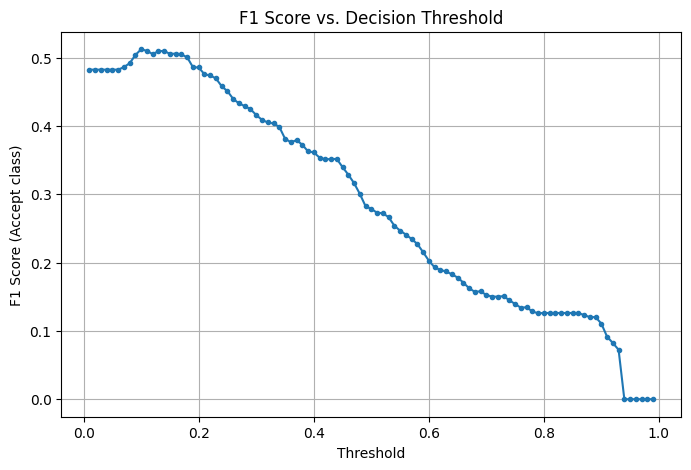

(np.float64(0.09999999999999999), 0.5123799898938858)

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.linspace(0.01, 0.99, 99)

f1_scores = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Accept class)")
plt.title("F1 Score vs. Decision Threshold")
plt.grid(True)
plt.show()

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
best_t, best_f1


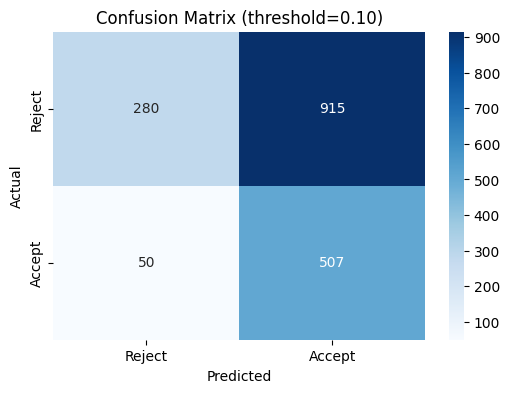

In [16]:
import seaborn as sns

best_preds = (probs >= best_t).astype(int)  # use tuned threshold
cm = confusion_matrix(labels, best_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Reject", "Accept"],
            yticklabels=["Reject", "Accept"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={best_t:.2f})")
plt.show()


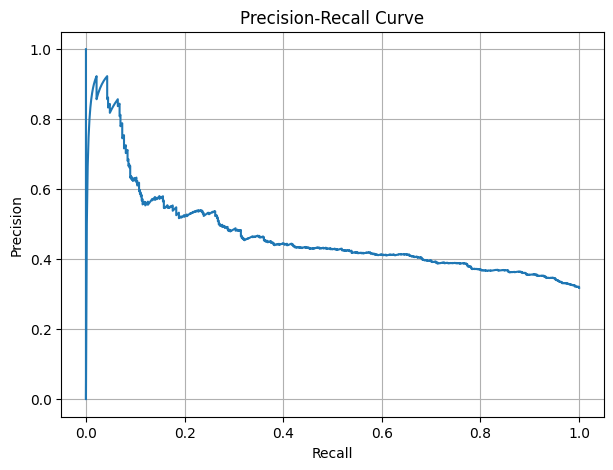

In [17]:
from sklearn.metrics import precision_recall_curve

prec, rec, th = precision_recall_curve(labels, probs)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()
